# Importações

In [1]:
import torch
from torch_geometric import utils
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric.nn as pyg_nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
import networkx as nx

# Parâmetros

In [2]:
def arg_parse():
    parametros = argparse.ArgumentParser(description='Cassificação de letras do alfabeto.')

    parametros.set_defaults(
            epocas = 500,
            modelo = 'GIN', # GIN, GCN, GAT
            batch_size = 16,
            hidden_dim = 30,
            num_layers = 2,
            weight_decay = 3e-4,
            dropout = 0.1,
            learningrate = 0.001
    )
    return parametros.parse_known_args()

# Dataset

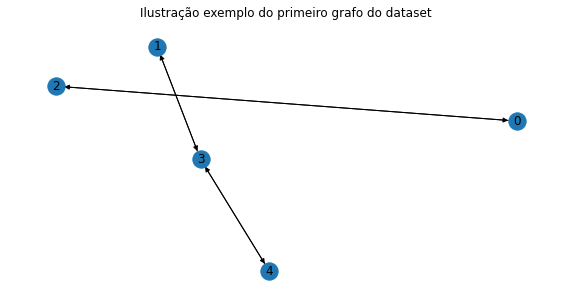

In [3]:
# Carrega os parâmetros
args, unknown = arg_parse()

# Carrega o dataset (low, med ou high)
pyg_dataset = TUDataset('./Letter-low', 'Letter-low', use_node_attr = True)
#pyg_dataset = TUDataset('./Letter-med', 'Letter-med', use_node_attr = True)
#pyg_dataset = TUDataset('./Letter-high', 'Letter-high', use_node_attr = True)

# Remove grafos sem arestas
pyg_dataset = [g for g in pyg_dataset if g.num_edges > 0]      

# convertendo p/ nx
graphsg = []
for i in range (len(pyg_dataset)):
    # Adiciona grafo networkx 
    graphsg.append(utils.to_networkx(pyg_dataset[i]))
    
# Exemplo ilustrativo (primeiro grafo do dataset)
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_title('Ilustração exemplo do primeiro grafo do dataset')
nx.draw_kamada_kawai(graphsg[0], with_labels=True, ax=ax)    

# Converte os grafos para formato Deep Snap
graphs = GraphDataset.pyg_to_graphs(pyg_dataset, netlib=nx)

# Cria o objeto dataset Deep Snap
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph = 0)

# Validação Cruzada

In [4]:
# Divisão em treino (80%), validação (10%) e teste (10%)
datasets = {}
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
            transductive=False, split_ratio = [0.8, 0.1, 0.1])

# Geração do DataLoader com o tamanho do lote
data = {split: DataLoader(
                dataset, collate_fn=Batch.collate(), 
                batch_size=args.batch_size, shuffle=True)
                for split, dataset in datasets.items()}

# Variáveis de número de classes e de atributos dos vértices 
num_classes = datasets['train'].num_graph_labels
num_node_features = datasets['train'].num_node_features

# Otimizador

In [5]:
def otimizador(args, params):
    # Velocidade do decaimento
    weight_decay = args.weight_decay
    # Filtro de correção de gradiente p/ uma nova rede
    filter_fn = filter(lambda p : p.requires_grad, params)
    # Otimizador Adam
    optimizer = optim.Adam(filter_fn, lr=args.learningrate, weight_decay=weight_decay)
    
    return optimizer

# GIN

In [6]:
# Classe da Rede de Isomorfismo de Grafos (GIN) 
class GIN(torch.nn.Module):
    # Argumentos: dimensão de entrada, dimensão oculta, dimensão de saída e parâmetros 
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GIN, self).__init__()
        # Quantidade de camadas
        self.num_layers = args.num_layers
        
        # Cria a camada de entrada
        self.pre_mp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim))

        # Cria as camadas ocultas convolucionais GIN
        self.convs = nn.ModuleList()
        self.nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.convs.append(pyg_nn.GINConv(self.nn1))
        
        for l in range(args.num_layers-1):
            self.nnk = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
            self.convs.append(pyg_nn.GINConv(self.nnk))

        # Cria a camada de saída   
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), ReLU(), nn.Linear(hidden_dim, output_dim))

    # Propagação    
    def forward(self, data):
        # Carregando dados de treino
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        # Propagando X pela camada de entrada 
        x = self.pre_mp(x)
        # Propagando pelas camadas ocultas
        for i in range(len(self.convs)):
            # Carregando edge_index e atualizando x pelas camadas ocultas
            x = self.convs[i](x, edge_index)
            # "Filtrando" pela ativação ReLU
            x = F.relu(x)
        # Camada de sum pooling dos vértices do grafo     
        x = pyg_nn.global_add_pool(x, batch)
        # Camada de saída
        x = self.post_mp(x)
        # "Filtrando" pela ativação softmax
        x = F.log_softmax(x, dim=1)
        return x

    # Função de perda dado o valor predito e real
    def loss(self, pred, label):
        return F.nll_loss(pred, label)

# GNN

In [7]:
# Classe da Rede Neural em Grafos (GNN) 
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        # Droupout
        self.dropout = args.dropout
        # Quantidade de camadas
        self.num_layers = args.num_layers

        # Cria a camada de entrada
        conv_model = self.build_conv_model(args.modelo)
        
        # Cria as camadas ocultas convolucionais GNN
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))

        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # Cria a camada de saída    
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            ReLU(),
            nn.Linear(hidden_dim, output_dim))

    # Verificação do tipo de GNN    
    def build_conv_model(self, tipo_modelo):
        if tipo_modelo == 'GCN':
            return pyg_nn.GCNConv
        elif tipo_modelo == 'GAT':
       	    return pyg_nn.GATConv
        else:
            raise ValueError("Modelo {} não está presente no GNN.build_conv_model.".format(tipo_modelo))

    # Propagação        
    def forward(self, data):
        # Carregando dados de treino
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        # Propagando pelas camadas da rede
        for i in range(len(self.convs)):
            # Carregando edge_index e atualizando x pelas camadas ocultas 
            x = self.convs[i](x, edge_index)
            # "Filtrando" pela ativação ReLU
            x = F.relu(x)
            # Executando dropout para "esquecer" neurônios
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Camada de sum pooling dos vértices do grafo         
        x = pyg_nn.global_add_pool(x, batch)
        # Camada de saída
        x = self.post_mp(x)
        # "Filtrando" pela ativação softmax
        x = F.log_softmax(x, dim=1)
        return x

    # Função de perda dado o valor predito e real
    def loss(self, pred, label):
        return F.nll_loss(pred, label)

# Treino

In [8]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes):
    # Verificação do tipo de GNN    
    if args.modelo == "GIN":
        modeloesc = GIN
    else:
        modeloesc = GNN

    # Inicializa o modelo escolhido    
    modelo = modeloesc(num_node_features, args.hidden_dim, num_classes, args).to("cpu")
    # Inicializa o otimizador
    opt = otimizador(args, modelo.parameters())

    # Laço de épocas
    for epoch in range(args.epocas):
        # Perda acumulada
        total_loss = 0
        # Treino do modelo
        modelo.train()
        # Quantidade de grafos treinados
        num_grafos = 0
        # Para cada lote no conjunto de treino
        for batch in train_loader:
            # Device CPU
            batch.to("cpu")
            # Inicializa gradiente 0
            opt.zero_grad()
            # Predição
            pred = modelo(batch)
            # Valor real correspondente
            label = batch.graph_label
            # Cálculo da perda
            loss = modelo.loss(pred, label)
            # Cálcula o gradiente
            loss.backward()
            # Atualiza os parâmetros do otimizador
            opt.step()
            # Incrementa a perda acumulada
            total_loss += loss.item() * batch.num_graphs
            # Incrementa a quantidade de grafos treinados
            num_grafos += batch.num_graphs
        # Retorna a loss média por grafo
        total_loss /= num_grafos

        # Teste de acurácia de treino, teste e validação
        train_acc = test(train_loader, modelo)
        val_acc = test(val_loader, modelo)
        test_acc = test(test_loader, modelo)
        print("Época {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}".format(epoch + 1, train_acc, val_acc, test_acc, total_loss))

# Teste

In [9]:
def test(loader, modelo):
    # Modelo treinado
    modelo.eval()

    # Acertos da rede neural
    corretos = 0
    # Quantidade de grafos testados
    num_grafos = 0
    for batch in loader:
        # Device CPU
        batch.to("cpu")
        with torch.no_grad():
            # Valor predito e real
            pred = modelo(batch).max(dim=1)[1]
            label = batch.graph_label
        # Se forem iguais incrementa quantidade de acertos
        corretos += pred.eq(label).sum().item()
        # Incrementa a quantidade de grafos testados 
        num_grafos += batch.num_graphs
    # Retorna a acurácia média por grafo
    return corretos / num_grafos

# Execução

In [10]:
# Execução do treino
train(data['train'], data['val'], data['test'], 
            args, num_node_features, num_classes)

Época 1: Train: 0.2698, Validation: 0.2902. Test: 0.2356, Loss: 2.5370
Época 2: Train: 0.4738, Validation: 0.4464. Test: 0.4489, Loss: 1.9155
Época 3: Train: 0.5190, Validation: 0.5402. Test: 0.4844, Loss: 1.5328
Época 4: Train: 0.7157, Validation: 0.7500. Test: 0.7156, Loss: 1.2356
Época 5: Train: 0.7737, Validation: 0.8125. Test: 0.7867, Loss: 1.0467
Época 6: Train: 0.8227, Validation: 0.8482. Test: 0.8311, Loss: 0.9294
Época 7: Train: 0.7670, Validation: 0.7857. Test: 0.7956, Loss: 0.8276
Época 8: Train: 0.7821, Validation: 0.8080. Test: 0.8178, Loss: 0.7699
Época 9: Train: 0.8528, Validation: 0.8750. Test: 0.8711, Loss: 0.7034
Época 10: Train: 0.8439, Validation: 0.8616. Test: 0.8444, Loss: 0.6503
Época 11: Train: 0.8645, Validation: 0.8839. Test: 0.8711, Loss: 0.6142
Época 12: Train: 0.8668, Validation: 0.8571. Test: 0.8622, Loss: 0.5626
Época 13: Train: 0.8768, Validation: 0.8795. Test: 0.8800, Loss: 0.5937
Época 14: Train: 0.8322, Validation: 0.8482. Test: 0.8622, Loss: 0.5237
É